# Importar librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
# select top 10 features using mRMR
from mrmr import mrmr_classif

# Funciones auxiliares

In [2]:
def matriz_correlacion(dataset, target):
    corr_matrix = dataset.corr()
    corr_matrix[target].sort_values(ascending=False)
    #from matplotlib.colors import ListedColormap
    #cm_blue_orange = ListedColormap(['tab:blue', 'orange'])
    cm_red_blue = mpl.colormaps['RdBu']
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cm_red_blue, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Heatmap con Valores Numéricos y Colores')
    # Mostrar el gráfico
    plt.show()

In [3]:
# Calcular el VIF para cada característica
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [4]:
# # Función para entrenar y evaluar un modelo
# def train_evaluate_model(model, X_train, X_test, y_train, y_test):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calcular RMSE
#     r2 = r2_score(y_test, y_pred)
#     return rmse, r2

In [5]:
# Función para entrenar y evaluar el modelo
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    
    return rmse_train, r2_train, rmse_test, r2_test


# Preprocesamiento

In [6]:
average_cluster_3=pd.read_csv("../data/interim/average_series_cluster_3.csv",parse_dates=["Date/Time"])

In [7]:
average_cluster_3.shape

(8783, 7)

In [8]:
average_cluster_3.head()

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
0,2004-01-01 01:00:00,161.387407,16.394480,26.970423,0.0,43.513342,52.539744
1,2004-01-01 02:00:00,156.571442,16.303037,22.348740,0.0,43.513342,52.539744
2,2004-01-01 03:00:00,170.833916,25.161407,27.599414,0.0,43.513342,52.539744
3,2004-01-01 04:00:00,157.000881,16.670542,22.405555,0.0,43.513342,52.539744
4,2004-01-01 05:00:00,171.708903,25.424457,27.787371,0.0,43.513342,52.539744


In [9]:
average_cluster_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Date/Time                                   8783 non-null   datetime64[ns]
 1   Electricity:Facility [kW](Hourly)           8395 non-null   float64       
 2   Fans:Electricity [kW](Hourly)               8395 non-null   float64       
 3   Cooling:Electricity [kW](Hourly)            8395 non-null   float64       
 4   Heating:Electricity [kW](Hourly)            8395 non-null   float64       
 5   InteriorLights:Electricity [kW](Hourly)     8395 non-null   float64       
 6   InteriorEquipment:Electricity [kW](Hourly)  8395 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 480.4 KB


In [10]:
average_cluster_3.isna().sum()

Date/Time                                       0
Electricity:Facility [kW](Hourly)             388
Fans:Electricity [kW](Hourly)                 388
Cooling:Electricity [kW](Hourly)              388
Heating:Electricity [kW](Hourly)              388
InteriorLights:Electricity [kW](Hourly)       388
InteriorEquipment:Electricity [kW](Hourly)    388
dtype: int64

In [11]:
# Imputar o eliminar valores faltantes si existen
average_cluster_3.fillna(method='ffill', inplace=True)

In [12]:
average_cluster_3.isna().sum()

Date/Time                                     0
Electricity:Facility [kW](Hourly)             0
Fans:Electricity [kW](Hourly)                 0
Cooling:Electricity [kW](Hourly)              0
Heating:Electricity [kW](Hourly)              0
InteriorLights:Electricity [kW](Hourly)       0
InteriorEquipment:Electricity [kW](Hourly)    0
dtype: int64

In [13]:
# Establecer la columna de fecha como índice
average_cluster_3.set_index('Date/Time', inplace=True)

In [14]:
# Extraer características temporales
average_cluster_3['hour'] = average_cluster_3.index.hour
average_cluster_3['day_of_week'] = average_cluster_3.index.dayofweek
average_cluster_3['month'] = average_cluster_3.index.month

In [15]:
average_cluster_3.head()

,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),hour,day_of_week,month
Date/Time,,,,,,,,,
2004-01-01 01:00:00,161.387407,16.394480,26.970423,0.0,43.513342,52.539744,1,3,1
2004-01-01 02:00:00,156.571442,16.303037,22.348740,0.0,43.513342,52.539744,2,3,1
2004-01-01 03:00:00,170.833916,25.161407,27.599414,0.0,43.513342,52.539744,3,3,1
2004-01-01 04:00:00,157.000881,16.670542,22.405555,0.0,43.513342,52.539744,4,3,1
2004-01-01 05:00:00,171.708903,25.424457,27.787371,0.0,43.513342,52.539744,5,3,1


In [16]:
average_cluster_3.columns

Index(['Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month'],
      dtype='object')

In [17]:
target='Electricity:Facility [kW](Hourly)'

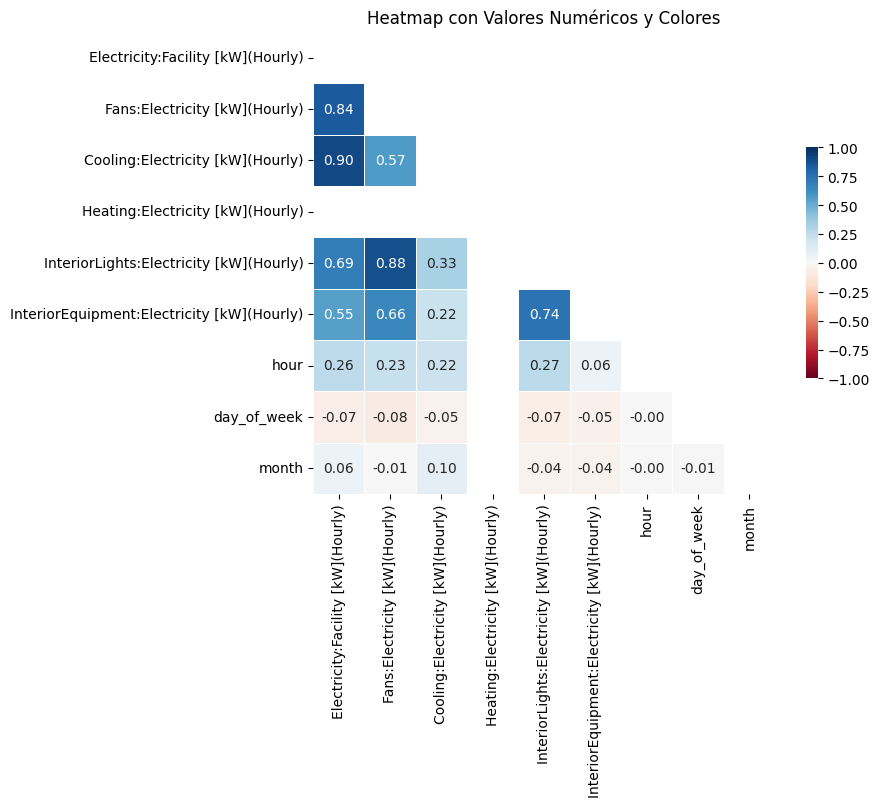

In [18]:
matriz_correlacion(average_cluster_3, target)

In [19]:
X=average_cluster_3.drop(columns=target)
y=average_cluster_3.loc[:,target]

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.75it/s]


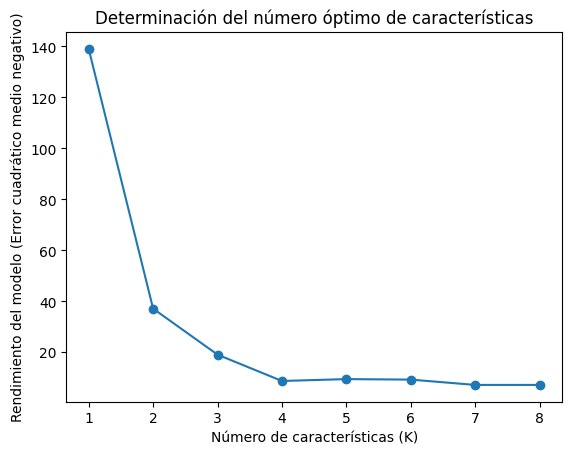

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from mrmr import mrmr_classif
import pandas as pd
from sklearn.datasets import make_regression

performance = []
k_pruebas = len(X.columns)

for k in range(1, k_pruebas + 1):  # Probar desde 1 hasta todas las características
    selected_features = mrmr_classif(X=X, y=y, K=k)
    X_selected = X[selected_features]
    
    # Evaluar el modelo con validación cruzada
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X_selected, y, cv=5, scoring='neg_root_mean_squared_error')  # Usar MSE como métrica
    performance.append(scores.mean())

# Convertir el rendimiento a valores positivos si se usa 'neg_mean_squared_error'
performance = [-x for x in performance]

plt.plot(range(1, k_pruebas + 1), performance, marker='o')
plt.xlabel('Número de características (K)')
plt.ylabel('Rendimiento del modelo (Error cuadrático medio negativo)')
plt.title('Determinación del número óptimo de características')
plt.show()

In [21]:
selected_features = mrmr_classif(X=X, y=y, K=4)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


In [22]:
selected_features

['Fans:Electricity [kW](Hourly)',
 'Cooling:Electricity [kW](Hourly)',
 'InteriorLights:Electricity [kW](Hourly)',
 'InteriorEquipment:Electricity [kW](Hourly)']

In [23]:
 taget_predict=average_cluster_3['Electricity:Facility [kW](Hourly)'].copy()

In [24]:
features_selected_corr=average_cluster_3.loc[:,selected_features].copy()

# Seleccion del modelo

In [25]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(features_selected_corr, taget_predict, test_size=0.2, random_state=42)

In [26]:
# Escalar las características
scaler_corr = StandardScaler()
X_train_scaled_corr = scaler_corr.fit_transform(X_train_corr)
X_test_scaled_corr = scaler_corr.transform(X_test_corr)

In [27]:
# Definición de modelos
models = {
    "Linear Regression": LinearRegression(),
    "Stepwise Linear Regression": Lasso(alpha=0.01),  # Utilizando Lasso como aproximación a la regresión paso a paso
    "Tree": DecisionTreeRegressor(),
    "SVM": SVR(kernel='rbf'),
    "Efficient Linear": LinearRegression(),  # Utilizando Linear Regression como proxy
    "Ensemble": VotingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('lasso', Lasso(alpha=0.01)),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Variables para almacenar resultados y modelos entrenados
results = {}
trained_models = {}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    rmse_train, r2_train, rmse_test, r2_test = train_evaluate_model(model, X_train_scaled_corr, X_test_scaled_corr, y_train_corr, y_test_corr)
    results[model_name] = {
        'RMSE Train': rmse_train, 
        'R2 Train': r2_train,
        'RMSE Test': rmse_test, 
        'R2 Test': r2_test
    }
    # Guardar el modelo entrenado en el diccionario
    trained_models[model_name] = model

In [28]:
# Convertir a DataFrame y verificar overfitting
df_overfitting_results= pd.DataFrame(results)
df_overfitting_results.head()

,Linear Regression,Stepwise Linear Regression,Tree,SVM,Efficient Linear,Ensemble,Random Forest
RMSE Train,6.548271,6.548423,3.182057,40.617117,6.548271,5.370909,3.947544
R2 Train,0.999554,0.999554,0.999895,0.982825,0.999554,0.999700,0.999838
RMSE Test,6.425843,6.427659,8.931255,36.324589,6.425843,6.234407,7.315883
R2 Test,0.999563,0.999562,0.999155,0.986027,0.999563,0.999588,0.999433


# Mejorar hiperparametros

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # Validación cruzada de 3 pliegues
                           n_jobs=-1,  # Usar todos los núcleos disponibles
                           scoring='neg_root_mean_squared_error',  # Usar RMSE
                           verbose=2)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train_scaled_corr, y_train_corr)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

In [ ]:
print("Mejores hiperparámetros:", best_params)

In [ ]:
# Entrenar el modelo con los mejores hiperparámetros
optimized_rf_model = RandomForestRegressor(**best_params, random_state=42)
optimized_rf_model.fit(X_train_scaled_corr, y_train_corr)

# Evaluar el modelo optimizado
rmse_train_opt = np.sqrt(mean_squared_error(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr)))
r2_train_opt = r2_score(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr))

rmse_test_opt = np.sqrt(mean_squared_error(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr)))
r2_test_opt = r2_score(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr))

# Resultados
optimized_rf_results = {
    "Optimized Random Forest": {
        'RMSE Train': rmse_train_opt,
        'R2 Train': r2_train_opt,
        'RMSE Test': rmse_test_opt,
        'R2 Test': r2_test_opt
    }
}

In [ ]:
# Mostrar los resultados
print("Resultados del modelo Random Forest optimizado:")
optimized_rf_results_df=pd.DataFrame(optimized_rf_results)
optimized_rf_results_df